PHASE-1: Multi- NASA DATA Ingestion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load & Inspect Dataset


In [3]:
nasa_files = [
    "B0045_telemetry.csv",
    "B0005_telemetry.csv",
    "B0043_telemetry.csv",
    "B0049_telemetry.csv",
    "B0054_telemetry.csv"
]


Load & Process Each Battery

In [9]:
all_nasa = []

for file in nasa_files:

    print(f"\nProcessing {file}...")

    df = pd.read_csv(file)

    battery_id = file.split("_")[0]
    device_name = f"NASA_{battery_id}"

    # -----------------------------
    # Compute SoH (Realistic Scaling)
    # Scale 1.0 → 0.7 instead of 0.0
    # -----------------------------
    max_cycle = df["cycle_index"].max()

    df["soh"] = 1 - 0.3 * (df["cycle_index"] / max_cycle)
    df["soh"] = df["soh"].clip(0.7, 1.0)

    # -----------------------------
    # Compute SOC from voltage
    # -----------------------------
    v_min, v_max = 3.0, 4.2
    df["soc"] = ((df["voltage"] - v_min) / (v_max - v_min)) * 100
    df["soc"] = df["soc"].clip(0, 100)

    # -----------------------------
    # Convert time → timestamp
    # -----------------------------
    start_time = pd.Timestamp.now()
    df["timestamp"] = start_time + pd.to_timedelta(df["time"], unit="s")

    # -----------------------------
    # Add metadata
    # -----------------------------
    df["device_id"] = device_name
    df["event"] = "normal"
    df["source"] = "nasa"

    # -----------------------------
    # Standardized Telemetry Schema
    # -----------------------------
    telemetry_df = pd.DataFrame({
        "device_id": df["device_id"],
        "timestamp": df["timestamp"],
        "pack_voltage": df["voltage"],
        "current": df["current"],
        "temperature": df["temperature"],
        "soc": df["soc"],
        "cycle_count": df["cycle_index"],
        "soh": df["soh"],
        "event": df["event"],
        "source": df["source"]
    })

    all_nasa.append(telemetry_df)



Processing B0045_telemetry.csv...

Processing B0005_telemetry.csv...

Processing B0043_telemetry.csv...

Processing B0049_telemetry.csv...

Processing B0054_telemetry.csv...


Merge All NASA Batteries

In [10]:
nasa_df = pd.concat(all_nasa, ignore_index=True)

print("\nNASA Devices:", nasa_df["device_id"].unique())
print("Total NASA Batteries:", nasa_df["device_id"].nunique())
print("Total Rows:", len(nasa_df))

print("\nSoH Range Per Device:")
print(nasa_df.groupby("device_id")["soh"].agg(["min", "max"]))



NASA Devices: ['NASA_B0045' 'NASA_B0005' 'NASA_B0043' 'NASA_B0049' 'NASA_B0054']
Total NASA Batteries: 5
Total Rows: 1335777

SoH Range Per Device:
            min  max
device_id           
NASA_B0005  0.7  1.0
NASA_B0043  0.7  1.0
NASA_B0045  0.7  1.0
NASA_B0049  0.7  1.0
NASA_B0054  0.7  1.0


Quick Sanity Plots

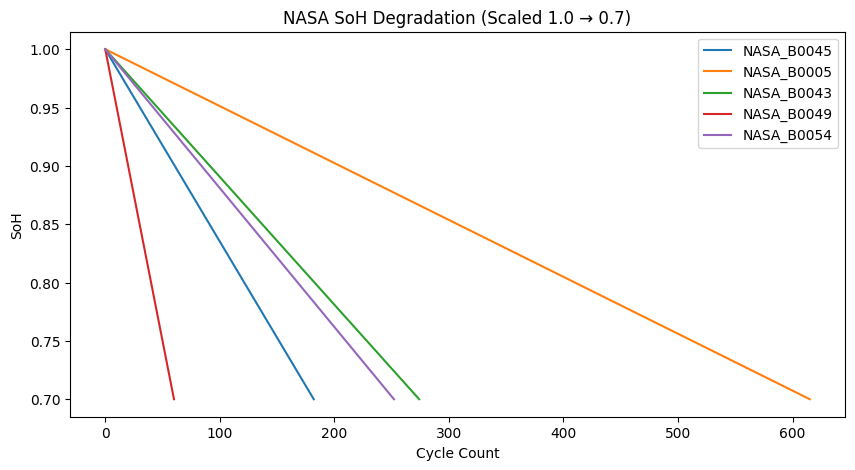

In [11]:
plt.figure(figsize=(10,5))

for dev in nasa_df["device_id"].unique():
    sample = nasa_df[nasa_df["device_id"] == dev].groupby("cycle_count")["soh"].first()
    plt.plot(sample, label=dev)

plt.title("NASA SoH Degradation (Scaled 1.0 → 0.7)")
plt.xlabel("Cycle Count")
plt.ylabel("SoH")
plt.legend()
plt.show()


In [12]:
nasa_df.to_csv("phase1_telemetry.csv", index=False)

nasa_df.to_json(
    "phase1_telemetry.jsonl",
    orient="records",
    lines=True
)

print("\nPhase 1 completed successfully")



Phase 1 completed successfully
